In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_curve,classification_report
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
import string
import nltk

In [3]:
train_data = pd.read_csv("/content/train_data.txt", header=None, sep=":::", names=["ID", "Title", "Genres","Description"], engine='python')
train_data.head()

,ID,Title,Genres,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4762 entries, 0 to 4761
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           4762 non-null   int64 
 1   Title        4762 non-null   object
 2   Genres       4762 non-null   object
 3   Description  4762 non-null   object
dtypes: int64(1), object(3)
memory usage: 148.9+ KB


In [5]:

train_data.isnull().sum()

ID             0
Title          0
Genres         0
Description    0
dtype: int64

In [7]:
test_path = "/content/test_data.txt"

test_data = pd.read_csv(test_path, sep=":::", names=["ID", "Title","Description"], engine="python")

test_data.head()

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18029 entries, 0 to 18028
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           18029 non-null  int64 
 1   Title        18029 non-null  object
 2   Description  18029 non-null  object
dtypes: int64(1), object(2)
memory usage: 422.7+ KB


In [9]:
test_data.isnull().sum()

ID             0
Title          0
Description    0
dtype: int64

In [10]:
import nltk
nltk.download('stopwords')

# Stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Function to clean
def clean_description(text):
    text = text.lower()  #
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
import nltk
nltk.download('punkt')

# Apply cleaning function to Description column
train_data['Clean_Description'] = train_data['Description'].apply(clean_description)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<ipython-input-12-cb6702a1c715>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, y="Genres", order=train_data["Genres"].value_counts().index, palette=palette)
<ipython-input-12-cb6702a1c715>:3: UserWarning: 
The palette list has fewer values (10) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=train_data, y="Genres", order=train_data["Genres"].value_counts().index, palette=palette)


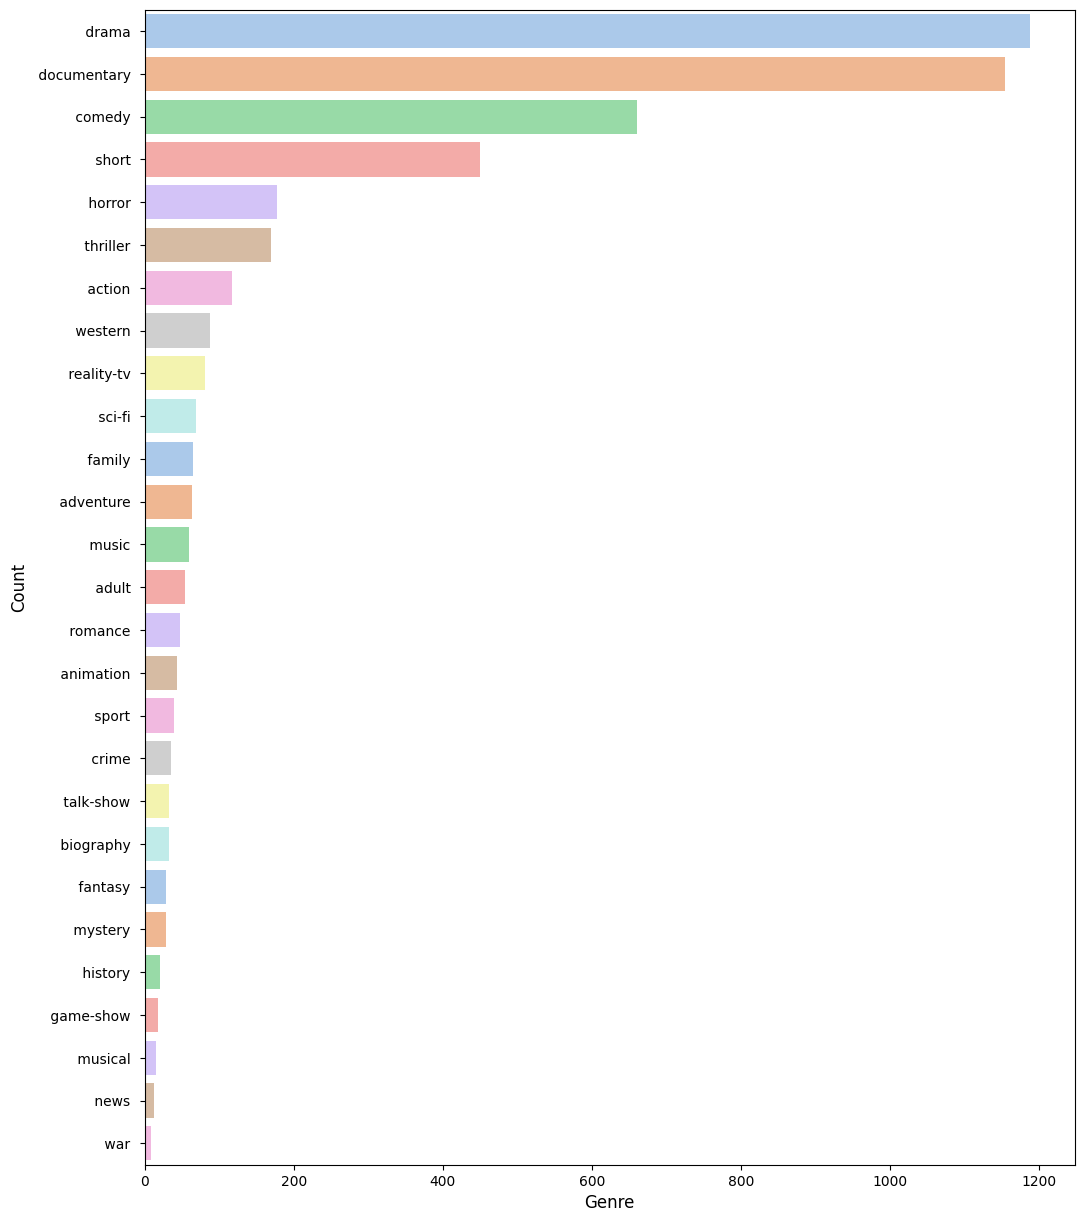

In [12]:
palette = sns.color_palette("pastel")
plt.figure(figsize=(12, 15))
sns.countplot(data=train_data, y="Genres", order=train_data["Genres"].value_counts().index, palette=palette)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.show()


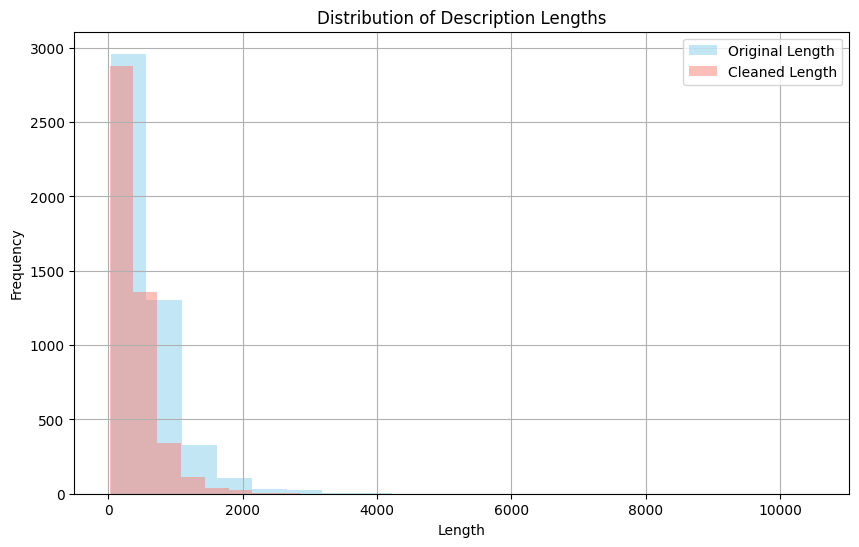

In [13]:
train_data['Original_Length'] = train_data['Description'].apply(len)
train_data['Cleaned_Length'] = train_data['Clean_Description'].apply(len)

# Plotting
plt.figure(figsize=(10, 6))

# Plot original lengths
plt.hist(train_data['Original_Length'], bins=20, color='skyblue', alpha=0.5, label='Original Length')

# Plot cleaned lengths
plt.hist(train_data['Cleaned_Length'], bins=20, color='salmon', alpha=0.5, label='Cleaned Length')

plt.title('Distribution of Description Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
removed_characters = sum(train_data['Original_Length'] - train_data['Cleaned_Length'])
print("Total characters removed during cleaning:", removed_characters)

Total characters removed during cleaning: 925272


In [15]:
X = train_data['Clean_Description'].iloc[:20000]
y = train_data['Genres'].iloc[:20000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=123)

In [16]:
vectorize = TfidfVectorizer()
X_train_tfidf  = vectorize.fit_transform(X_train)
X_test_tfidf  = vectorize.transform(X_test)

In [17]:
# Training the SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_tfidf, y_train)

SVC()

In [18]:
y_pred_val = svm_classifier.predict(X_test_tfidf)
valAccuracy = accuracy_score(y_test, y_pred_val)
print("Validation Accuracy:", valAccuracy)


Validation Accuracy: 0.4386149003147954
